# Introduction 

The following notebook provides a comprehensive overview and implementation of the [Private Aggregation of Teacher Ensembles (PATE)](https://arxiv.org/pdf/1610.05755.pdf) using [PyTorch](https://pytorch.org/) and [PySyft](https://github.com/OpenMined/PySyft). The dataset that is used is [Home Credit Default Dataset](https://www.kaggle.com/c/home-credit-default-risk/overview) which contains features about credit applicants drawn from the internal operations of a financial insititution as well as corresponding Credit Bureau data. The target is whether or not the appliant will default on their debt. The following sections contain a detailed a theoretical overview and subsequent implementation.

# Background

## Private AI

### Introduction to Private AI
A major concern of production machine learning systems is maintaining the privacy of the data that was used to train it. This is especially relevant in use cases with private and sensitive information. In the Private AI literature, a party looking to reveal information about the data that a model is trained on is called an adversary. Even if the adversary does not have access to the data explicitly, access to the model and/or its outputs can reveal information about the data that the model was trained on.

### Privacy Attacks
An adversary employs a privacy attack in order to reveal information about the data that the model was trained on. Two attacks that are well researched in the Private AI Literature: 
- **Model Inversion Attack:** Try to obtain information about typical samples in the training dataset. This involves attacks that euther reconst a specific sample or representative samples in the training dataset. 

- **Membership Inference Attack:** Try to ascertain whether or not a sample was used to train a model. 

### Threat Models
Each adversary has a threat model that informs the manner in which they go about a privacy attack. The threat model describes the level of access that an adverary has to a model. At a high level, there are two threat models: 
- **Black Box Adversary:** Solely able to query the model. Thus, the only information made available to the adversary is the inputs and outputs of the model. 
- **White Box Adversary:** The adversary is able to query the model as well as have access to its internal parameters. This implies that the adversary has access to the input, output and the intermediate computations made by the model. 

## Differential Privacy 

### Introduction to Differential Privacy
In order to evaluate the robustness of a model to privacy attacks, we have to define a framework through which we can obtain a quantitative measure that describes its performance in terms of privacy. To this end, Differential Privacy has been proposed and offers a powerful mechanism to assess and rank the privacy of models. It does so based on the sensitivity of a model to the inclusion of a specific sample.

<p align="center">
<img width="433" alt="Screen Shot 2021-09-28 at 5 41 20 PM" src="https://user-images.githubusercontent.com/34798787/137939981-a9968386-4a28-4447-ad9e-5babab497eeb.png">  
</p>
<center>
<a href=https://www.nist.gov/blogs/cybersecurity-insights/differential-privacy-privacy-preserving-data-analysis-introduction-our>Source</a>  
</center>



Specified formally, the definition of differential privacy is given by the below inequality: 
<p align="center">
<img width="185" alt="Screen Shot 2021-10-19 at 11 40 16 AM" src="https://user-images.githubusercontent.com/34798787/137944948-cffd9db8-5a29-4f98-bf5a-b5b7d4bbe25b.png">
</p>

where M is the model, x is orginal the dataset, x' is the original dataset augmented to include or exclude a single sample. $\epsilon$ acts as a metric of privacy loss based on a differential change in data. The smaller the value is, the better privacy protection. Rearranging the inequality yields:

<p align="center">
<img width="345" alt="Screen Shot 2021-10-19 at 3 37 50 PM" src="https://user-images.githubusercontent.com/34798787/137978800-d3c56d46-5b7c-4b37-a61e-6f7b8daa61d2.png">
</p>
This is a strong to guarentee to achieve in practice so a failure probability in order to relax this constraint we add a failure probability, $\delta$, to the RHS of the inequality: 

<p align="center">
<img width="400" alt="Screen Shot 2021-10-19 at 3 35 50 PM" src="https://user-images.githubusercontent.com/34798787/137978567-7a0313bc-d9cd-4a0d-9f9b-7df3711f2c3d.png">
</p>

As long as delta is smaller than the probability that a sample occurs in the dataset, we will still obtain a high degree of privacy. This allows us to relax the guarentee we need to provide while maintaining an acceptable level of privacy. As parameters that define the interval of differential privacy, a model with $\epsilon$ and $\delta$ is ($\epsilon$, $\delta$)-differentially private. 



### Composition in Differential Privacy
An important consideration in practice is determining the differential privacy of a composition of a number of models. Drawing from [The Algorithmic Foundations
of Differential Privacy](https://www.cis.upenn.edu/~aaroth/Papers/privacybook.pdf), the composition of k differentially private mechanisms, where the $i$th mechanism is ($\epsilon_{i}$, $\delta_{i}$)-differentially private, for 1 $\leq$ i $\leq$ k, is ($\sum \epsilon_{i}$, $\sum \delta_{i}$)-differentially private.



### Privacy Amplication Theorem
If we select a subset of samples from the dataset, it is intuitive that we would incur a privacy loss that is lower than that of using the entire dataset. This is the essence of the Privacy Amplication Theorem which states that if we randomly sample a q of the data, rather than the entrie dataset, then an ($\epsilon$, $\delta$) private mechansm becomes ($q\epsilon$, $q\delta$)-differentially private.



### Fundamental Law of Information Recovery
The Fundamental Law of Information Recovery states that overly accurate estimates of too many statistics erodes the privacy of data. This implies that continuously querying a private mechanism will increase the privacy loss incurred. 

### Implications for Training and Testing Machine Learning Models
Within the context of training and testing a machine learning model, we can use Composition in Differentially Privacy and Privacy Amplication Theorem to derive the privacy loss in situations where we are iteritvely querying a model with a random subset of the data, such as in the case of training and testing Neural Networks. The summation of privacy losses over queries follows the intuition from the Fundamental Law of Information Recovery that continuously querying a private mechanism will increase the privacy loss incurred. 

## Differentially Private Stochastic Gradient Descent (DP-SGD)

### Introduction to DP-SGD
The seminal paper that applies Differential Privacy to Deep Learning is [Deep Learing with Differential Privacy](https://arxiv.org/abs/1607.00133). In this paper, a differentially-private variant of stochastic gradient descent is proposed (DP-SGD). 

<p align="center">
<img width="500" alt="dpsgd" src="https://user-images.githubusercontent.com/34798787/138136971-c51261d3-73de-4afb-97b9-71e149ddfacd.png">
</p>

<center>
<a href=https://secml.github.io/class4>Source</a>  
</center>




### Estimating Differential Privacy for a Single Gradient Update
As in vanilla SGD, we start with calculating the gradient of a batch of data. In order to limit the amount information we learn from the batch, we clip the gradient at C which is a hyperpareter for the algorithim. We than add noise $\sigma^2$ proportional C and than update the parameters of the model. 
 


### Estimating Differential Privacy for accross Gradient Updates
In order to get the total privacy loss, we must aggregate the privacy loss for each gradient update. Based on Composition in Differential Privacy and The Privacy Amplicaiton Theorem, we can define a Naive estimate of the upper bound of the privacy loss. Given an ($\epsilon$, $\delta$)-differentially private algorithim, with a batch size proportional to $q$ run for T iterations has a differential privacy of ($Tq\epsilon$, $Tq\delta$). 

It turns out that a more complex analysis can yield lower bounds for the privacy loss. Thus, finding the lowest bound possible allows us to more accurately determine the privacy loss and to avoid overstimating it. For example, the Strong Compositon Theorem can be used to prove an even lower bound on the privacy loss. In the DP-SGD paper, the authors propose the Moments Accountant which provided the lowest bound 
- **Naive Analysis:** ($Tq\epsilon$, $Tq\delta$)-differentially private
- **Strong Composition Theorem:** ($O(q\epsilon\sqrt{Tlog(1/\delta)})$, $Tq\delta$)-differentially private
- **Moments Accountant:** ($O(q\epsilon\sqrt{T})$, $\delta$)-differentially private.



### Moments Accountant
The fundamental insight of the Moments Accountant technique is that the privacy loss is a random variable. Thus, if we look at the distribution of the privacy loss, we can see that $\epsilon$ defines the privacy budget for the loss and $\delta$ provides an upper bound on the tail of the distribution. 

<p align="center">
<img width="500" alt="Screen Shot 2021-10-20 at 1 50 02 PM" src="https://user-images.githubusercontent.com/34798787/138145128-0d67885f-a5c4-448f-9fcd-78fa0452a3ce.png">
</p>
<center>
<a href=https://www.youtube.com/watch?v=jm1Sfdno_5A>Source</a>  
</center>

By treating the privacy loss as a random variable, we can leverage probability theory to derive a lower bound on the privacy loss. Specifically, the Moments Accountant Technique uses the moments of the distribution (ie mean, variance, skewness and kurtosis) in order to do so. Incorporating the higher order information of the distibution made available through the moments  allows us to derive a lower bound on the privacy loss: $O(q\epsilon\sqrt{T})$, $\delta$). For a deeper look into the Moments Accountant technique, refer to [Deep Learing with Differential Privacy](https://arxiv.org/abs/1607.00133).






## Private Aggregation of Teacher Ensembles (PATE)


### Introduction to PATE
In [Scalable Private Learning with PATE](https://arxiv.org/abs/1802.08908), authors set out solve the problem of preserving the privacy of training data when training classfiers. They began with defining certain criteria for the solution:
- Differential privacy protection guarentees
- Intuitive privacy protection guarentees 
- **Independent of learning algorithim**

<p align="center">
<img width="500" alt="dpsgd" src="https://user-images.githubusercontent.com/34798787/139095511-ff27899c-80f0-45bf-a4d0-d18820c20e34.png">
</p>

<center>
<a href=https://www.youtube.com/watch?v=cjo_u_yT2wQ&t=1s>Source</a>  
</center>











### Ensembling

In differential privacy, we seek to learn general trends from the data. That is, the outcome of the the prediction of a sample, should be the same whether or not we choose to include an sample in the dataset for each sample in the dataset. One natural way to achieve this to use an ensemble of models trained on random subsets of the dataset. In this way, the prediction for a specific sample is less likely to depend on a single example. Furthermore, if there is a strong consensus among the ensemble, it is likely the prediction stems from a general trend rather than a specific sample. In practice, this allows us to define a lower, data dependent bound on the privacy loss. 

Although ensembling enhances differentially privacy, it is still possible that the inclusion/exclusion of samples in the various teachers will change the outcome of the predictions. This is especially the case when there is not a strong consensus among the ensemble; the vote of single teacher can sway the prediction of the output. 




### Noisy Aggregation

In order to address the aforementioned shortcoming, we can aggregate the votes of the teachers in a noisy way. This is realized by adding noise to the final prediction.

<p align="center">
<img width="500" alt="dpsgd" src="https://user-images.githubusercontent.com/34798787/139089966-fa783578-cc52-4a58-bcb4-9a06432868ac.png">
</p>
<center>
<a href=https://www.youtube.com/watch?v=cjo_u_yT2wQ&t=1s>Source</a>  
</center>




### Student Training
Although the aggregated teacher is a good step towards differential privacy, it does have some shortcomings: 
- Each prediction increases total privacy loss. Thus, the privacy budget creates a tradeoff between the accuracy and number of predictions.
- Inspection of internal may reveal private data. However, we want privacy guarentees that hold for white box adversaries. 

As a result, the PATE framework introduces a student network that is trained on publicly available data using labels from Teacher Model.

<p align="center">
<img width="500" alt="dpsgd" src="https://user-images.githubusercontent.com/34798787/138165916-a61f044d-4d45-4f5f-8e62-3fca94b65b84.png">
</p>
<center>
<a href=https://www.youtube.com/watch?v=cjo_u_yT2wQ&t=1s>Source</a>  
</center>


# Outline:


* Membership Inference Attacks (MIA) on Machine Learning Models
  * Definition
  * Types of Membership Inference Attacks
  * Membership Inference Attack Methods
  * Defences Against Membership Inference Attacks

*   Membership Inference Attack in Tensorflow Privacy

*   Defending the Membership Inference Attacks Using Differential Privacy in Tensorflow Privacy

* References




# Membership Inference Attacks (MIA) on Machine Learning Models 
## Definition

* MIA on machine learning models aim to identify whether a data sample
was used to train the target machine learning model or not

  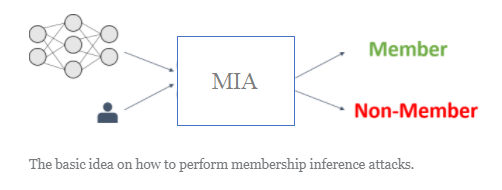



* MIA can raise severe privacy risks to
individuals. For example, identifying that a certain patient’s clinical record was used to train a model associated with a disease reveals that the patient has this disease

## Types of Membership Inference Attacks

### MIA against ML models mainly focus on deep learning models because they are more prone to suffer from overfitting issues, which can be exploited by membership inference attacks

### Based on what information is available to the adversary, i.e., adversarial knowledge, membership inference attacks can be divided as follows:


*  Black-box inference attacks
*  White-box inference attacks


### Adversarial knowledge categorization
* Data knowledge: Knowledge of the data distribution of 𝐷𝑡𝑟𝑎𝑖𝑛
* Training knowledge:  Optimization algorithm, number of training steps, settings of the optimization algorithm,
etc.
* Model knowledge:
  *  Model architecture: Type of neural network, the number of layers, the type of activation function, etc. 
  *  Model parameters
* Output knowledge:
  * Full output knowledge 
  * Partial output knowledge
  * Label-only knowledge

###Generally, the adversary is assumed to have data knowledge, training knowledge, and output knowledge of the target model. Based on whether the adversary can have access to the model knowledge of model parameters, MIA can be categorized into **black-box** and **white-box** inference attacks. In the following Table, we compare and intuitively demonstrate these two types of inferences.












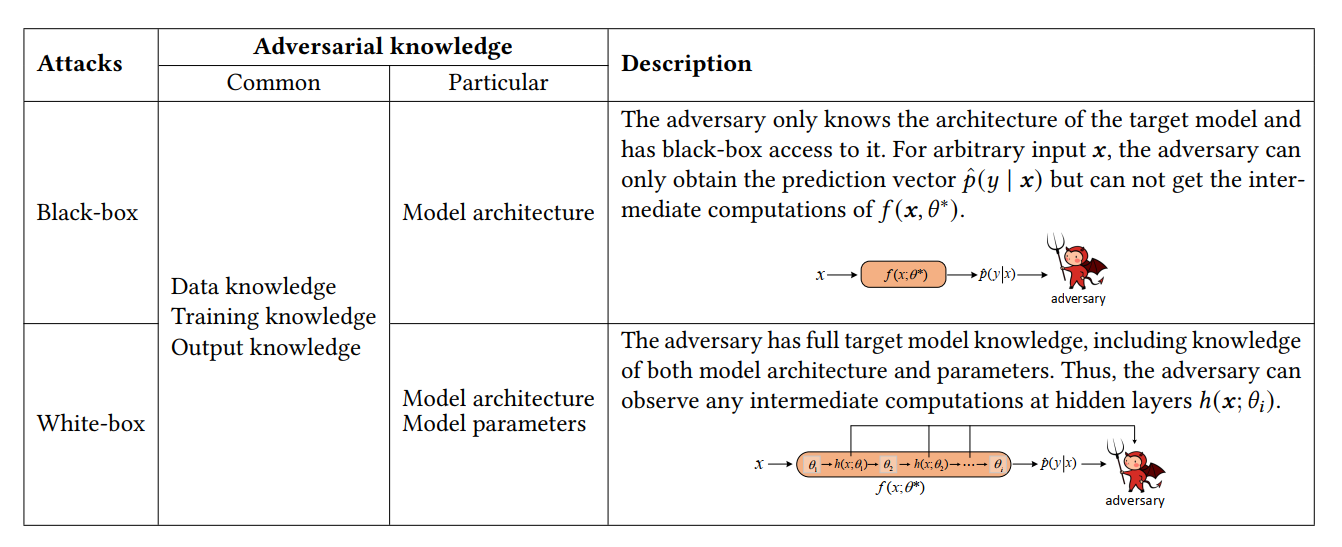


## Membership Inference Attack (MIA) Methods

### If our ML method behaves differently on test and train datasets, this model is vulnerable to MIA. This means the ML methods that overfit on the train data are more vulnerable to MIA.

### There are two types of MIA attacks:
   * Neural network based attacks
   * Metric based attacks

### Neural network based attacks

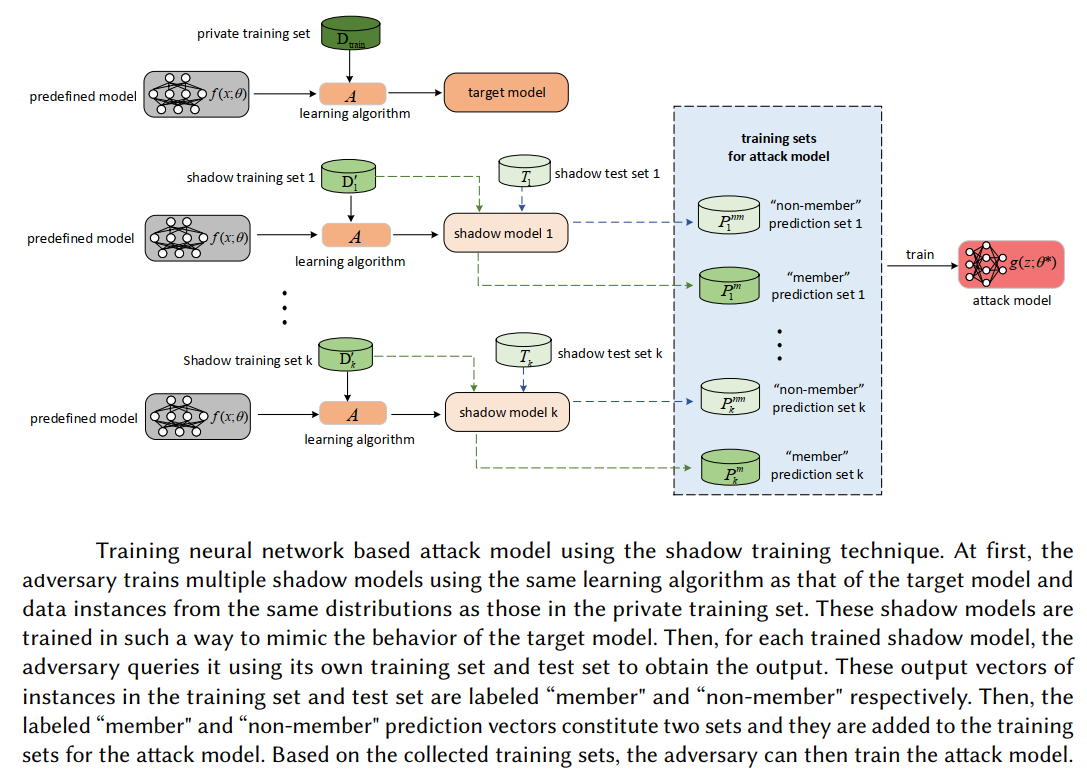

### Metric based attacks
* Prediction correctness based attack
* Prediction loss based attack
* Prediction confidence based attack
* Prediction entropy based attack

## Defences Against Membership Inference Attacks
* Confidence score masking
* Regularization
* Differential privacy

# Demo

In [36]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow import keras
import math

import tensorflow as tf

#for reproducible results
import random

from tensorflow_privacy.privacy.analysis.rdp_accountant import compute_rdp
from tensorflow_privacy.privacy.analysis.rdp_accountant import get_privacy_spent
from tensorflow_privacy.privacy.optimizers.dp_optimizer_keras import DPKerasSGDOptimizer
from tensorflow_privacy.privacy.optimizers import dp_optimizer
import tensorflow_privacy

#for logging
import sys
import logging
import datetime

import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import Sequential, layers
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
import sklearn
from imblearn.under_sampling import RandomUnderSampler
from keras.regularizers import l2
from imblearn.over_sampling import SMOTE
from tensorflow.keras.utils import to_categorical
from scipy import special
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.layers import PReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow_privacy.privacy.membership_inference_attack import membership_inference_attack as mia
from tensorflow_privacy.privacy.membership_inference_attack.data_structures import AttackInputData
from tensorflow_privacy.privacy.membership_inference_attack.data_structures import SlicingSpec
from tensorflow_privacy.privacy.membership_inference_attack.data_structures import AttackType
import tensorflow_privacy.privacy.membership_inference_attack.plotting as plotting
from tensorflow_privacy.privacy.optimizers.dp_optimizer_keras import DPKerasSGDOptimizer

import tensorflow_privacy.privacy.privacy_tests.membership_inference_attack
from scipy import special

/ssd003/projects/aieng/public/pets_unified/lib/python3.8/site-packages/tensorflow_privacy/privacy/membership_inference_attack/__init__.py:18: UserWarning: 
Membership inference attack sources were moved. Please replace
import tensorflow_privacy.privacy.membership_inference_attack

with
import tensorflow_privacy.privacy.privacy_tests.membership_inference_attack
  warnings.warn(


In [2]:
%load_ext tensorboard


In [3]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
data_dir = "/ssd003/projects/pets/datasets/home_credit"
# home_credit_train_df = pd.read_csv(f"{data_dir}/home_credit_train.csv")
# credit_bureau_train_df = pd.read_csv(f"{data_dir}/credit_bureau_train.csv")
data_df = pd.read_csv(f"{data_dir}/train.csv")

# Preparing the dataset to train


In [5]:
train_df, test_df = train_test_split(data_df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

In [6]:
# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('target'))
val_labels = np.array(val_df.pop('target'))
test_labels = np.array(test_df.pop('target'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

In [7]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)

## Oversampling


In [8]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()

X_train_oversampled, y_oversampled = oversample.fit_resample(train_features, train_labels)

## Define the model metrics


In [9]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    # underfitting. 
    model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
    ])
#     model = tf.keras.Sequential([
#         tf.keras.layers.Dense(40, input_shape=(train_features.shape[-1],), activation='relu'),
#         tf.keras.layers.Dropout(0.3),
#         tf.keras.layers.Dense(60, activation='relu'),
#         tf.keras.layers.Dropout(0.3),
#         tf.keras.layers.Dense(20, activation='relu'),
#         tf.keras.layers.Dropout(0.3),
#         tf.keras.layers.Dense(1, activation='sigmoid')
#     ])
#     model = tf.keras.Sequential([
#         tf.keras.layers.Dense(80, input_shape=(train_features.shape[-1],), activation='relu'),
#         tf.keras.layers.Dropout(0.4),
#         tf.keras.layers.Dense(80, activation='relu'),
#         tf.keras.layers.Dropout(0.2),
#         tf.keras.layers.Dense(40, activation='relu'),
#         tf.keras.layers.Dense(1, activation='sigmoid')
#     ])

    model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

    return model

In [10]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

In [11]:
EPOCHS = 100
BATCH_SIZE = 2048
# BATCH_SIZE = 250

early_stopping = tf.keras.callbacks.EarlyStopping(
#     monitor='val_prc', 
    monitor="val_auc",
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

## Check training history


In [12]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

## Evaluate metrics

You can use a confusion matrix to summarize the actual vs. predicted labels, where the X axis is the predicted label and the Y axis is the actual label.



In [13]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

    print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
    print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
    print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
    print('Total Fraudulent Transactions: ', np.sum(cm[1]))

## ROC

In [14]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5,100.5])
    plt.ylim([0,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

## AUPRC

In [15]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

In [16]:
resampled_features = X_train_oversampled
resampled_labels = y_oversampled

## Performance


In [17]:
def evaluate_models(keras_model, train_features, train_labels, test_features, test_labels, BATCH_SIZE):
    train_predictions = keras_model.predict(train_features, batch_size=BATCH_SIZE)
    test_predictions = keras_model.predict(test_features, batch_size=BATCH_SIZE)
    test_prediction_results = keras_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
    for name, value in zip(keras_model.metrics_names, test_prediction_results):
        print(name, ": ", value)
    print()
    plot_cm(test_labels, test_predictions)
    print()
    print("Plot ROC")
    plot_roc("Train Resampled", train_labels, train_predictions, color=colors[2])
    plot_roc("Test Resampled", test_labels, test_predictions, color=colors[2], linestyle='--')
    plt.legend(loc='lower right')
    plt.title("ROC")
    plt.show()
    
    print()
    print("Plot Precision-Recall Curve")
    plot_prc("Train Resampled", train_labels, train_predictions, color=colors[2])
    plot_prc("Test Resampled", test_labels, test_predictions, color=colors[2], linestyle='--')
    plt.legend(loc='lower right')
    plt.title("Precision Recall Curve")
    plt.show()

## DP-SGD

In [18]:
def compute_epsilon(steps, training_size, noise_multiplier, batch_size):
    """Computes epsilon value for given hyperparameters."""
    if noise_multiplier == 0.0:
        return float('inf')

    #rule of thumb for delta is to set it to less than the inverse of the training data size
    #so I opted for it to equal to 1.1*training size
    training_delta = 1 / (training_size *1.1) 

    orders = np.linspace(1+math.log(1./training_delta)/10, 1+math.log(1./training_delta)/1, num=100)
    #if you want epsilon between 1-10 and your delta is fixed
    # your orders must cover the range between 1+ln(1/delta)/10 and 1+ln(1/delta)/1

    sampling_probability = batch_size / training_size
    rdp = compute_rdp(q=sampling_probability,
                    noise_multiplier=noise_multiplier,
                    steps=steps,
                    orders=orders)

    return get_privacy_spent(orders, rdp, target_delta=training_delta)[0], training_delta

In [19]:
def train(dpsgd, batch_size, microbatches, l2_norm_clip, noise_multiplier, learning_rate, epochs, 
          resampled_features, resampled_labels, print_output = True, verbose = 0):
    #logging.set_verbosity(logging.INFO)
    if dpsgd and batch_size % microbatches != 0:
        raise ValueError('Number of microbatches should divide evenly batch_size')

    # Define a sequential Keras model
    resampled_dp_model = make_model()

    # Reset the bias to zero, since this dataset is balanced.
    #output_layer = resampled_dp_model.layers[-1] 
    #output_layer.bias.assign([0])

    if dpsgd:
        optimizer = DPKerasSGDOptimizer(
            l2_norm_clip=l2_norm_clip,
            noise_multiplier=noise_multiplier,
            num_microbatches=microbatches,
            learning_rate=learning_rate)
        # Compute vector of per-example loss rather than its mean over a minibatch.
        loss = tf.keras.losses.BinaryCrossentropy(reduction=tf.losses.Reduction.NONE)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        loss = tf.keras.losses.BinaryCrossentropy()

    # Compile model with Keras
    resampled_dp_model.compile(optimizer=optimizer, loss=loss, metrics=METRICS)

    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    training_size = resampled_features.shape[0]

    # Train model with Keras
    resampled_dp_history = resampled_dp_model.fit(
        resampled_features, resampled_labels,
        epochs=epochs,
#         steps_per_epoch=resampled_steps_per_epoch,
        callbacks=[early_stopping, tensorboard_callback], #monitor='val_prc', higher = better
        validation_data=(val_features, val_labels),
        verbose = verbose)
    
    score_train = resampled_dp_model.evaluate(resampled_features, resampled_labels, verbose=verbose)
    score_val = resampled_dp_model.evaluate(val_features, val_labels, verbose=verbose)
    score_test = resampled_dp_model.evaluate(test_features, test_labels, verbose=verbose)

    weights = resampled_dp_model.get_weights()

    # Compute the privacy budget expended.
    if dpsgd:
        eps, delta = compute_epsilon(epochs * training_size // batch_size, training_size=training_size, 
                                     noise_multiplier=noise_multiplier, batch_size=batch_size)
        if print_output:
            print('For delta=%.4f, the current epsilon is: %.2f' % (delta, eps))
    else:
        if print_output:
            print('Trained with vanilla non-private SGD optimizer')

    if print_output:
        print("Training Result")
        for name, value in zip(resampled_dp_model.metrics_names, score_train):
            print(name, ': ', value)
        print()
        print("Validation Result")
        for name, value in zip(resampled_dp_model.metrics_names, score_val):
            print(name, ': ', value)
        print()
        print("Testing Result")
        for name, value in zip(resampled_dp_model.metrics_names, score_test):
            print(name, ': ', value)
        print()     

    if dpsgd:
        return resampled_dp_model, score_train, score_val, score_test, eps, delta, weights, resampled_dp_history
    
    return resampled_dp_model, score_train, score_val, score_test, weights, resampled_dp_history 

## DP-SGD model

In [20]:
from time import time


In [21]:
tic = time()
resampled_dp_model, score_train, score_val, score_test, eps, delta, weights, resampled_dp_history = train(dpsgd=True, batch_size=BATCH_SIZE, microbatches=1, l2_norm_clip=1.0, 
      noise_multiplier=1.0, learning_rate=0.001, epochs=EPOCHS, 
      resampled_features=resampled_features, resampled_labels=resampled_labels,print_output=True, verbose = 1)
toc = time()
print("Time used to train dp-sgd model: {}", toc - tic)

Epoch 1/100
11311/11311 [==============================] - 71s 6ms/step - loss: 0.7291 - tp: 75297.0000 - fp: 52568.0000 - tn: 128404.0000 - fn: 105675.0000 - accuracy: 0.5628 - precision: 0.5889 - recall: 0.4161 - auc: 0.5872 - prc: 0.5763 - val_loss: 0.6078 - val_tp: 2100.0000 - val_fp: 11963.0000 - val_tn: 33197.0000 - val_fn: 1942.0000 - val_accuracy: 0.7174 - val_precision: 0.1493 - val_recall: 0.5195 - val_auc: 0.6791 - val_prc: 0.1595
Epoch 2/100
11311/11311 [==============================] - 65s 6ms/step - loss: 0.6724 - tp: 86911.0000 - fp: 52621.0000 - tn: 128351.0000 - fn: 94061.0000 - accuracy: 0.5947 - precision: 0.6229 - recall: 0.4802 - auc: 0.6351 - prc: 0.6168 - val_loss: 0.6151 - val_tp: 2194.0000 - val_fp: 11791.0000 - val_tn: 33369.0000 - val_fn: 1848.0000 - val_accuracy: 0.7228 - val_precision: 0.1569 - val_recall: 0.5428 - val_auc: 0.6936 - val_prc: 0.1718
Epoch 3/100
11311/11311 [==============================] - 65s 6ms/step - loss: 0.6638 - tp: 91459.0000 - fp:

loss :  0.6147666573524475
tp :  2697.0
fp :  14845.0
tn :  41709.0
fn :  2252.0
accuracy :  0.722013533115387
precision :  0.15374529361724854
recall :  0.5449585914611816
auc :  0.6945993304252625
prc :  0.17693489789962769



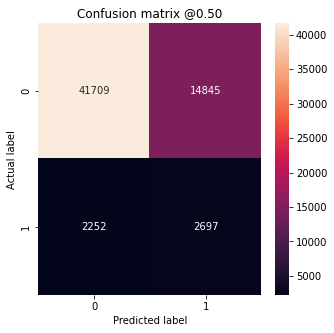

Legitimate Transactions Detected (True Negatives):  41709
Legitimate Transactions Incorrectly Detected (False Positives):  14845
Fraudulent Transactions Missed (False Negatives):  2252
Fraudulent Transactions Detected (True Positives):  2697
Total Fraudulent Transactions:  4949

Plot ROC


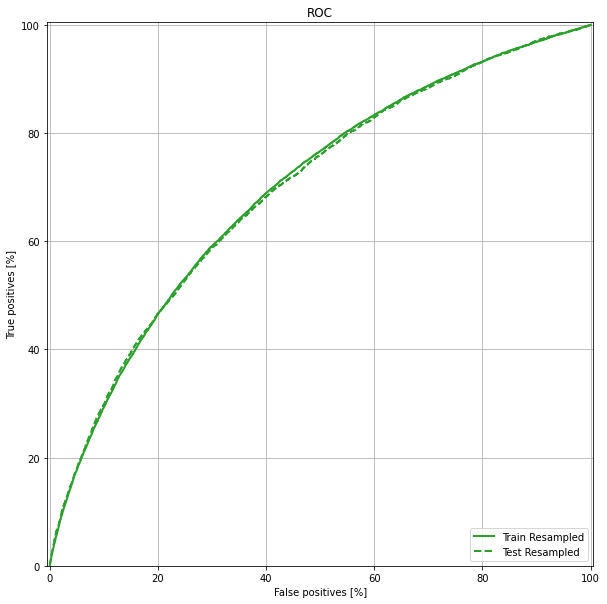


Plot Precision-Recall Curve


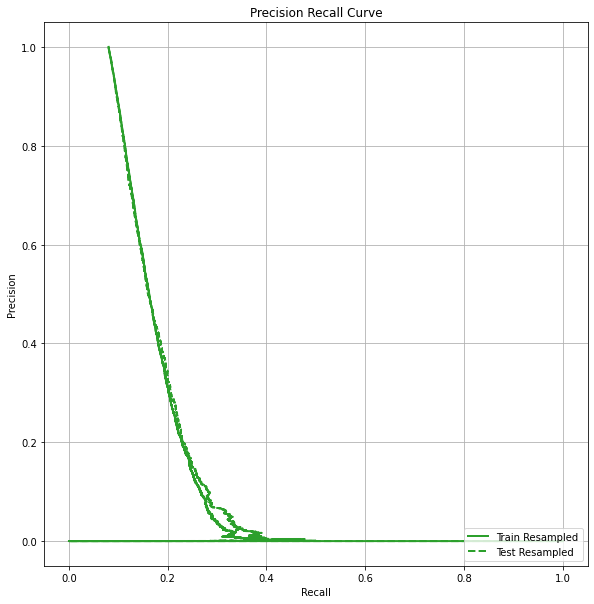

In [22]:
evaluate_models(resampled_dp_model, train_features, train_labels, test_features, test_labels, BATCH_SIZE)

In [23]:
%tensorboard --logdir logs/fit


ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

## Hyperparameter tuning to reduce epsilon

Two metrics are used to express the DP guarantee of an ML algorithm:

1.Delta () - Bounds the probability of the privacy guarantee not holding. A rule of thumb is to set it to be less than the inverse of the size of the training dataset. In this tuturial, delta is set to a fixed value.

2.Epsilon () - Measures the strength of the privacy guarantee by bounding how much the probability of a particular model output can vary by including (or excluding) a single training point. A smaller value for  implies a better privacy guarantee. However, the  value is only an upper bound and a large value could still mean good practical privacy.

Note:

<li>smaller epsilon = better</li>
<li> ε=0 (and δ=0 in the general case) is equivalent to absolute privacy. </li>
</li>

## Hyperparameters that need to be tuned for DP-SGD:

<li>l2_norm_clip (float)</li>

<li>noise_multiplier (float)</li>

<li>microbatches (int)</li>

<li>learning_rate (float)</li>

In [24]:
tic = time()
resampled_model, score_train, score_val, score_test, weights, resampled_history = train(dpsgd=False, batch_size=BATCH_SIZE, microbatches=1, l2_norm_clip=1.0, 
      noise_multiplier=1.0, learning_rate=0.001, epochs=EPOCHS, 
      resampled_features=resampled_features, resampled_labels=resampled_labels,print_output=True, verbose = 1)
toc = time()
print("Time to train non-dp model; ", toc - tic)

Epoch 1/100
11311/11311 [==============================] - 57s 5ms/step - loss: 0.6073 - tp: 126895.0000 - fp: 75181.0000 - tn: 162345.0000 - fn: 59026.0000 - accuracy: 0.6831 - precision: 0.6280 - recall: 0.6825 - auc: 0.7345 - prc: 0.6656 - val_loss: 0.5751 - val_tp: 2693.0000 - val_fp: 15246.0000 - val_tn: 29914.0000 - val_fn: 1349.0000 - val_accuracy: 0.6627 - val_precision: 0.1501 - val_recall: 0.6663 - val_auc: 0.7228 - val_prc: 0.1986
Epoch 2/100
11311/11311 [==============================] - 54s 5ms/step - loss: 0.5909 - tp: 138852.0000 - fp: 70221.0000 - tn: 110751.0000 - fn: 42120.0000 - accuracy: 0.6896 - precision: 0.6641 - recall: 0.7673 - auc: 0.7520 - prc: 0.7169 - val_loss: 0.5899 - val_tp: 2694.0000 - val_fp: 15424.0000 - val_tn: 29736.0000 - val_fn: 1348.0000 - val_accuracy: 0.6591 - val_precision: 0.1487 - val_recall: 0.6665 - val_auc: 0.7211 - val_prc: 0.1984
Epoch 3/100
11311/11311 [==============================] - 54s 5ms/step - loss: 0.5885 - tp: 139636.0000 - f

loss :  0.5784140229225159
tp :  3334.0
fp :  18508.0
tn :  38046.0
fn :  1615.0
accuracy :  0.6728127002716064
precision :  0.15264169871807098
recall :  0.6736714243888855
auc :  0.7362292408943176
prc :  0.21321001648902893



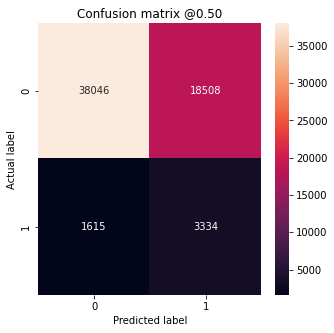

Legitimate Transactions Detected (True Negatives):  38046
Legitimate Transactions Incorrectly Detected (False Positives):  18508
Fraudulent Transactions Missed (False Negatives):  1615
Fraudulent Transactions Detected (True Positives):  3334
Total Fraudulent Transactions:  4949

Plot ROC


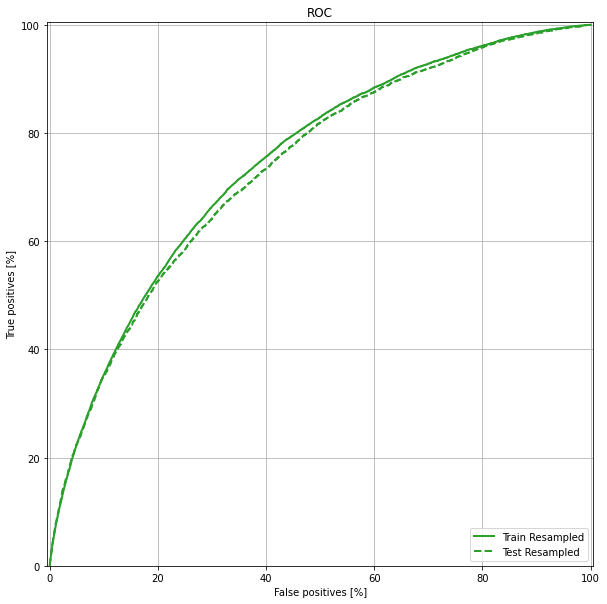


Plot Precision-Recall Curve


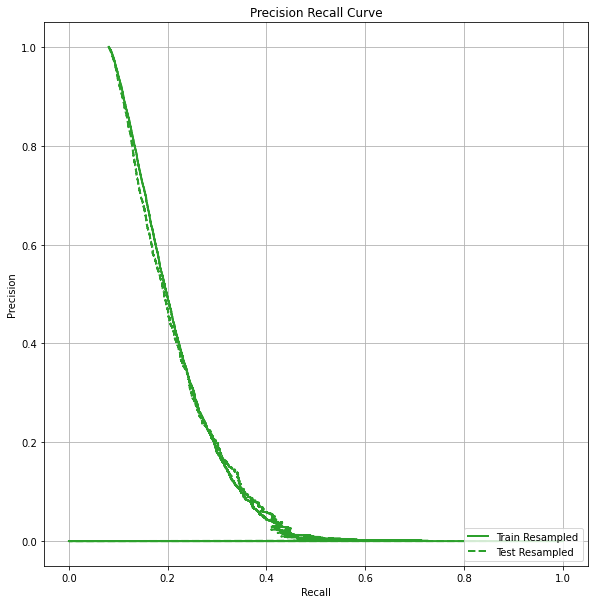

In [25]:
evaluate_models(resampled_model, train_features, train_labels, test_features, test_labels, BATCH_SIZE)


In [26]:
%tensorboard --logdir logs/fit


ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

## non-DP Model

In [27]:
def train_hp_tuning(dpsgd, batch_sizes, microbatches_list, l2_norm_clips, 
                    noise_multipliers, learning_rate, epochs,  model_dir=None, print_output = False, verbose = 0):
    
    table_outputs = []
    for batch_size in batch_sizes:
        for microbatches in microbatches_list:
            for l2_norm_clip in l2_norm_clips:
                for noise_multiplier in noise_multipliers:

                    _, score_train, score_val, score_test, eps, delta, _, _ = train(dpsgd=dpsgd, 
                                        batch_size=batch_size, microbatches=microbatches, l2_norm_clip=l2_norm_clip,
                                        noise_multiplier=noise_multiplier, learning_rate=learning_rate, 
                                        epochs=epochs, resampled_features=resampled_features, resampled_labels=resampled_labels,
                                        print_output=print_output, verbose = verbose)
                    
                    table_outputs.append([learning_rate, noise_multiplier, l2_norm_clip, epochs, batch_size, microbatches,
                                        score_train[0], score_train[6],  score_train[7],  score_train[8], score_train[9], 
                                        score_val[0],  score_val[6],  score_val[7],  score_val[8],  score_val[9], 
                                        score_test[0], score_test[6], score_test[7], score_test[8], score_test[9], 
                                        eps, delta])

                
    df = pd.DataFrame(table_outputs, columns=['learning rate', 'noise multiplier', 'L2 norm clip',
                                                'Epochs', 'Batch size', 'Microbatches', 
                                              'Training loss', 'Training precision', 'Training recall', 'Training AUC', 'Training PRC', 
                                              'Validation loss', 'Validation precision', 'Validation recall', 'Validation AUC', 'Validation PRC', 
                                              'Test loss', 'Test precision', 'Test recall', 'Test AUC', 'Test PRC', 
                                              'Epsilon', 'Delta'])

    return df

In [28]:
noise_multipliers = [1, 3, 5]
l2_norm_clips = [0.9, 1.0, 1.1]
# batch_sizes = [1024, 2048]
batch_sizes = [1024]
microbatches_list = [1]

training_outputs = train_hp_tuning(dpsgd=True,  batch_sizes = batch_sizes,
                                   microbatches_list=microbatches_list,
                                   l2_norm_clips=l2_norm_clips, 
                                   noise_multipliers=noise_multipliers, 
                                    learning_rate=0.0005, epochs=100,  model_dir=None,
                                    print_output = False, verbose = 0)

Restoring model weights from the end of the best epoch: 23.
Epoch 00033: early stopping
Restoring model weights from the end of the best epoch: 7.
Epoch 00017: early stopping
Restoring model weights from the end of the best epoch: 6.
Epoch 00016: early stopping
Restoring model weights from the end of the best epoch: 27.
Epoch 00037: early stopping
Restoring model weights from the end of the best epoch: 2.
Epoch 00012: early stopping
Restoring model weights from the end of the best epoch: 5.
Epoch 00015: early stopping
Restoring model weights from the end of the best epoch: 16.
Epoch 00026: early stopping
Restoring model weights from the end of the best epoch: 2.
Epoch 00012: early stopping
Restoring model weights from the end of the best epoch: 2.
Epoch 00012: early stopping


In [29]:
training_outputs.sort_values(by=['Validation PRC', 'Epsilon'], ascending=[False, True])
training_outputs

,learning rate,noise multiplier,L2 norm clip,Epochs,Batch size,Microbatches,Training loss,Training precision,Training recall,Training AUC,...,Validation recall,Validation AUC,Validation PRC,Test loss,Test precision,Test recall,Test AUC,Test PRC,Epsilon,Delta
0,0.0005,1,0.9,100,1024,1,0.595937,0.664043,0.756029,0.749352,...,0.687778,0.709768,0.178335,0.599856,0.138515,0.702566,0.718441,0.182816,3.435756,0.000003
1,0.0005,3,0.9,100,1024,1,0.641553,0.624106,0.708198,0.691785,...,0.667491,0.666282,0.151327,0.652687,0.119638,0.667812,0.668032,0.153020,0.953165,0.000003
2,0.0005,5,0.9,100,1024,1,0.660243,0.615038,0.653173,0.659317,...,0.617763,0.639835,0.129455,0.654783,0.116891,0.617094,0.637588,0.124915,0.801555,0.000003
3,0.0005,1,1.0,100,1024,1,0.599158,0.674108,0.721355,0.748718,...,0.659080,0.710315,0.185848,0.593802,0.141263,0.659931,0.715496,0.194728,3.435756,0.000003
4,0.0005,3,1.0,100,1024,1,0.661570,0.595193,0.707435,0.659003,...,0.636319,0.610433,0.118449,0.700322,0.106591,0.652253,0.620362,0.119965,0.953165,0.000003
5,0.0005,5,1.0,100,1024,1,0.677091,0.585695,0.596346,0.613026,...,0.592776,0.619597,0.118511,0.674872,0.110403,0.595474,0.616802,0.116510,0.801555,0.000003
6,0.0005,1,1.1,100,1024,1,0.600372,0.664835,0.733544,0.745143,...,0.672687,0.709025,0.183729,0.596285,0.139660,0.689836,0.716701,0.194449,3.435756,0.000003
7,0.0005,3,1.1,100,1024,1,0.688755,0.631001,0.269594,0.611081,...,0.289213,0.622327,0.125536,0.555421,0.138865,0.290160,0.618560,0.123277,0.953165,0.000003
8,0.0005,5,1.1,100,1024,1,0.675391,0.606033,0.586892,0.640731,...,0.555418,0.619099,0.121314,0.608933,0.113486,0.560113,0.623530,0.121861,0.801555,0.000003


In [30]:
training_outputs.to_csv("training_outputs.csv", index=False)


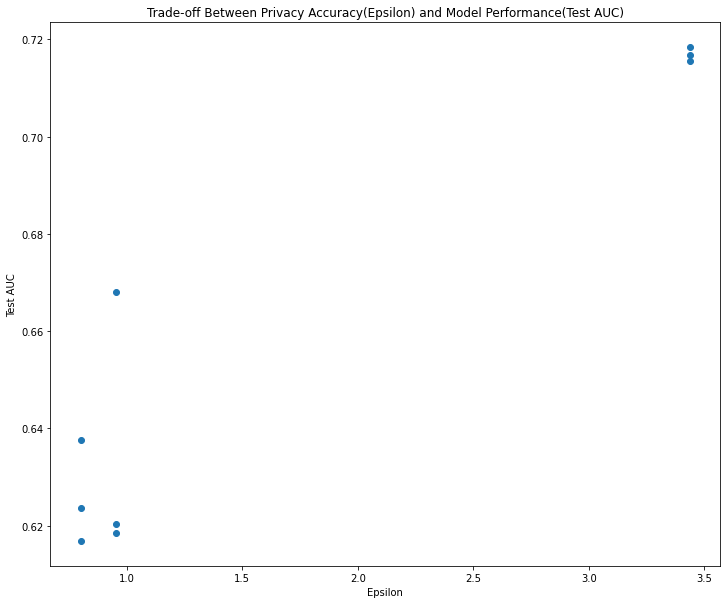

In [31]:
training_outputs = pd.read_csv("training_outputs.csv")
plt.scatter(training_outputs['Epsilon'], training_outputs['Test AUC'])
plt.title("Trade-off Between Privacy Accuracy(Epsilon) and Model Performance(Test AUC)")
plt.ylabel("Test AUC")
plt.xlabel("Epsilon")
plt.show("Test AUC")

In [32]:
low_privacy_param = {'learning_rate' : 0.0005,
                     'noise_multiplier' :1,
                     'L2_clip' :0.9,
                     'batch_size' :1024}
high_privacy_param = {'learning_rate':0.0005,
                     'noise_multiplier':3,
                     'L2_clip':1,
                     'batch_size':1024}

## Adversarial Test
Adversarial Test is to test how the model will be affected if one sample is excluded from the training data. The way to measure the effect is to build the first model with all data and the second model with all data except one sample and compute the weight difference of these two models.

Randomly pick 5 samples from the train_df. Remove each sample to do the adversarial test.

Compare the weight difference for Non-DP model, low_privacy_SGD-DP model, and high_privacy_SGD-DP model

In [33]:
def adversarial_test(resampled_features, resampled_labels, sample_index_to_remove, privacy_param, dpsgd):
    # Remove the sample from training data
    resampled_features_adversarial = resampled_features.drop(index=sample_index_to_remove, axis=0)
    resampled_labels_adversarial = resampled_labels.drop(index=sample_index_to_remove, axis=0)
    
    learning_rate = privacy_param['learning_rate']
    noise_multiplier = privacy_param['noise_multiplier']
    L2_clip = privacy_param['L2_clip']
    batch_size = privacy_param['batch_size']
    
    model, score_train, score_val, score_test, model_weights, history = train(dpsgd=dpsgd, batch_size=batch_size, microbatches=1, l2_norm_clip=L2_clip, 
      noise_multiplier=noise_multiplier, learning_rate=learning_rate, epochs=EPOCHS, 
      resampled_features=resampled_features, resampled_labels=resampled_labels,print_output=False, verbose = 0)
    
    model_adversarial, score_train, score_val, score_test, model_adversarial_weights, history = train(dpsgd=dpsgd, batch_size=batch_size, microbatches=1, l2_norm_clip=L2_clip, 
      noise_multiplier=noise_multiplier, learning_rate=learning_rate, epochs=EPOCHS, 
      resampled_features=resampled_features_adversarial, resampled_labels=resampled_labels_adversarial,print_output=False, verbose = 0)
    
    return model, model_weights, model_adversarial, model_adversarial_weights

In [34]:
def compute_weight_diff(weights, weights_adversarial):
    #compute difference between model parameters
    diffs = []
    sums = []

    #obtain the pairwise difference between the two models by enumrating through each set of weights and biases
    for index, value in enumerate(non_dp_weights):
        diffs.append(np.abs(weights[index] - weights_adversarial[index]))
        sums.append(np.sum(np.abs(weights[index]) + np.abs(weights_adversarial[index])))

    overall_sum_model_weights = np.sum(sums)

    #flatten the list of diffs between model parameters into one long list
    diffs_flattened = np.concatenate([x.ravel() for x in diffs])

    #normalize each element in the flattened list by dividing by the overall sum of model weights
    diffs_flattened_normalized = diffs_flattened / overall_sum_model_weights

    #print(np.sum(diffs), np.sum(sums))
    #print(np.sum(np.divide(diffs,sums)), np.divide(np.sum(diffs), np.sum(sums)))

    normalized_mean_diff_dpsgd = np.mean(diffs_flattened_normalized)

#     print("the normalized mean difference between model weights trained with DP-SGD is: ", normalized_mean_diff_dpsgd)
    return normalized_mean_diff_dpsgd
    

In [35]:
resampled_features = pd.DataFrame(resampled_features)
resampled_labels = pd.DataFrame(resampled_labels)
data_size = len(resampled_features)

vanilla_param = low_privacy_param  # Only batch_size and learning rate will be used.

random.seed(1)
# sample_size = 10
sample_size = 5

removed_index_list = []
# vanilla model
non_dp_weight_diff_list = []
# high privacy
hp_weight_diff_list = []
# low privacy
lp_weight_diff_list = []

for i in range(sample_size):
    sample_index_to_remove = random.randint(0, data_size)
    removed_index_list.append(sample_index_to_remove)
    print("Remove index: {}".format(sample_index_to_remove))
    #adversarial test on vanilla models
    non_dp_model, non_dp_weights, non_dp_adversarial_model, non_dp_adversarial_weights = adversarial_test(resampled_features, resampled_labels, sample_index_to_remove, vanilla_param, dpsgd=False)
    weight_diff_non_dp = compute_weight_diff(non_dp_weights, non_dp_adversarial_weights)
    non_dp_weight_diff_list.append(weight_diff_non_dp)
    print("Weight difference for Vanilla model: {}".format(weight_diff_non_dp))
    
    # adversarial test on low privacy parameter models
    lp_dp_model, lp_dp_weights, lp_dp_adversarial_model, lp_dp_adversarial_weights = adversarial_test(resampled_features, resampled_labels, sample_index_to_remove, low_privacy_param, dpsgd=True)
    weight_diff_lp = compute_weight_diff(lp_dp_weights, lp_adversarial_weights)
    lp_weight_diff_list.append(weight_diff_lp)
    print("Weight difference for Low privacy: {}".format(weight_diff_lp))
    
    # adversarial test on high privacy parameter models
    hp_dp_model, hp_dp_weights, hp_dp_adversarial_model, hp_dp_adversarial_weights = adversarial_test(resampled_features, resampled_labels, sample_index_to_remove, high_privacy_param, dpsgd=True)
    weight_diff_hp = compute_weight_diff(hp_dp_weights, hp_adversarial_weights)
    hp_weight_diff_list.append(weight_diff_hp)
    print("Weight difference for High privacy: {}".format(weight_diff_hp))
    
    
adversarial_test_result = pd.DataFrame()
adversarial_test_result['removed index'] = removed_index_list
adversarial_test_result['weight_diff_non_dp'] = weight_diff_non_dp_list
adversarial_test_result['weight_diff_high_privacy'] = hp_weight_diff_list
adversarial_test_result['weight_diff_low_privacy'] = lp_weight_diff_list
adversarial_test_result.to_csv("adversarial_test_result.csv", index=False)
adversarial_test_result

Remove index: 70445
Restoring model weights from the end of the best epoch: 38.
Epoch 00048: early stopping
Restoring model weights from the end of the best epoch: 15.
Epoch 00025: early stopping
Weight difference for Vanilla model: 0.0004051264259032905
Restoring model weights from the end of the best epoch: 6.
Epoch 00016: early stopping


ValueError: too many values to unpack (expected 6)

## Membership Inference Attack

Same model but returning logits in case of MIA.

In [39]:
def make_model(logits, last_nodes):
    model = Sequential()
    model.add(Dense(16, activation='relu', input_shape=(resampled_features.shape[-1],)))
    model.add(Dropout(0.5))
    if not logits:
        model.add(Dense(last_nodes, activation='sigmoid'))
    else:
        model.add(Dense(last_nodes))    
    return model

def compiled_model(model, learning_rate=0.01, noise_multiplier=0.9, l2_norm_clip=0.9, dp=False):
    if dp:
        optimizer = DPKerasSGDOptimizer(
            l2_norm_clip=l2_norm_clip,
            noise_multiplier=noise_multiplier,
            num_microbatches=1,
            learning_rate=learning_rate)
        model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), \
                     optimizer=optimizer, metrics= [tf.keras.metrics.AUC(from_logits=True)])
    else:
        model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), \
                      optimizer='adam', metrics=[tf.keras.metrics.AUC(from_logits=True)])
    
    return model

### Experiment: to train with High_privacy and conduct an MIA and Low_privacy and conduct MIA

In [40]:
high_priv_model = compiled_model(model=make_model(logits=True, last_nodes=1), dp=True, \
                                learning_rate=high_privacy_param['learning_rate'], \
                                noise_multiplier=high_privacy_param['noise_multiplier'], \
                                l2_norm_clip=high_privacy_param['L2_clip'] \
                                )
low_priv_model = compiled_model(model=make_model(logits=True, last_nodes=1), dp=True, \
                                learning_rate=low_privacy_param['learning_rate'], \
                                noise_multiplier=low_privacy_param['noise_multiplier'], \
                                l2_norm_clip=low_privacy_param['L2_clip'] \
                                )

base_line_model = compiled_model(model=make_model(logits=True, last_nodes=1))

In [41]:
hist1 = high_priv_model.fit(resampled_features, resampled_labels, epochs=1000, batch_size=2048, \
                            validation_data=(test_features, test_labels))
hist2 = low_priv_model.fit(resampled_features, resampled_labels,  epochs=1000, batch_size=2048, \
                           validation_data=(test_features, test_labels))
hist3 = base_line_model.fit(resampled_features, resampled_labels, epochs=1000, batch_size=2048, \
                            validation_data=(test_features, test_labels))

Epoch 1/1000
177/177 [==============================] - 3s 7ms/step - loss: 0.9629 - auc: 0.4356 - val_loss: 1.1749 - val_auc: 0.4358
Epoch 2/1000
177/177 [==============================] - 1s 5ms/step - loss: 0.9295 - auc: 0.4401 - val_loss: 1.0707 - val_auc: 0.4432
Epoch 3/1000
177/177 [==============================] - 1s 5ms/step - loss: 0.8875 - auc: 0.4511 - val_loss: 0.9826 - val_auc: 0.4615
Epoch 4/1000
177/177 [==============================] - 1s 5ms/step - loss: 0.8680 - auc: 0.4571 - val_loss: 0.9814 - val_auc: 0.4586
Epoch 5/1000
177/177 [==============================] - 1s 5ms/step - loss: 0.8608 - auc: 0.4577 - val_loss: 0.9623 - val_auc: 0.4621
Epoch 6/1000
177/177 [==============================] - 1s 5ms/step - loss: 0.8566 - auc: 0.4608 - val_loss: 0.9573 - val_auc: 0.4659
Epoch 7/1000
177/177 [==============================] - 1s 5ms/step - loss: 0.8425 - auc: 0.4668 - val_loss: 0.9326 - val_auc: 0.4738
Epoch 8/1000
177/177 [==============================] - 1s 5ms

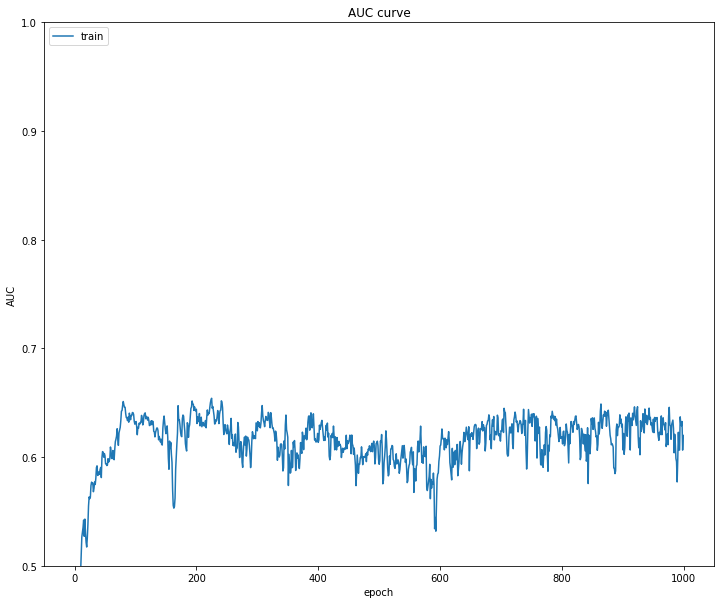

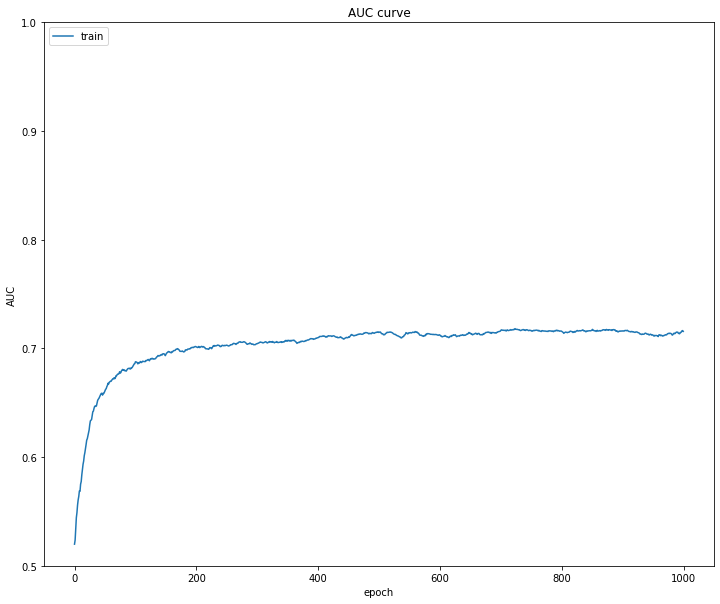

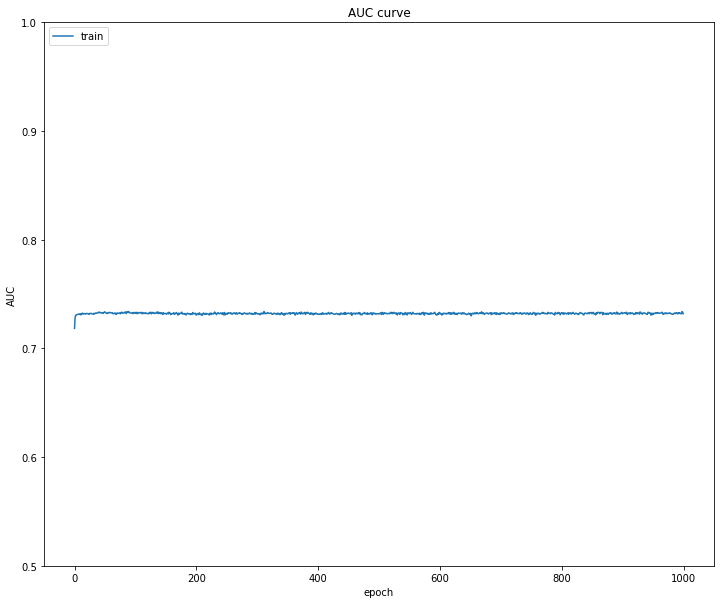

In [42]:
def plot_auc(history, key):
    plt.plot(history.history[key])
    plt.title('AUC curve')
    plt.ylabel('AUC')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.ylim(0.5, 1)
    plt.show()

plot_auc(hist1, 'val_auc')
plot_auc(hist2, 'val_auc_1')
plot_auc(hist3, 'val_auc_2')

In [43]:
def membership_inference_attack_binary(model, X_train, X_test, train_label, test_label):
    print('Predict on train...')
    logits_train = model.predict(X_train)

    print('Predict on test...')
    logits_test = model.predict(X_test)

    print('Apply softmax to get probabilities from logits...')
    prob_train = special.expit(logits_train)
    prob_test = special.expit(logits_test)
    y_train_pred = np.argmax(prob_train)
    y_test_pred = np.argmax(prob_test)
    
    print('Compute losses...')
    bce = tf.keras.backend.binary_crossentropy
    constant = tf.keras.backend.constant

    y_train = np.array(train_label, dtype=np.float32) 
    y_test =  np.array(test_label, dtype=np.float32) 

    y_train = y_train.flatten()
    y_test = y_test.flatten()
    
    loss_train = bce(constant(y_train), constant(y_train_pred), from_logits=False).numpy()
    loss_test = bce(constant(y_test), constant(y_test_pred), from_logits=False).numpy()
    
    attack_types = [
    AttackType.THRESHOLD_ATTACK,
    AttackType.LOGISTIC_REGRESSION,
    ]
    
    attack_input = AttackInputData(
      logits_train = logits_train,
      logits_test = logits_test,
      loss_train = loss_train,
      loss_test = loss_test,
      labels_train = y_train.astype(np.int8),
      labels_test = y_test.astype(np.int8)
    )
    slicing_spec = SlicingSpec(
    entire_dataset = True,
    by_class = True,
    by_percentiles = False,
    by_classification_correctness = True)
    
    attacks_result = mia.run_attacks(attack_input=attack_input,
                                 slicing_spec=slicing_spec,
                                 attack_types=attack_types)
    
    print(attacks_result.summary(by_slices=True))
        
    return plotting.plot_roc_curve(attacks_result.get_result_with_max_auc().roc_curve)

Predict on train...
Predict on test...
Apply softmax to get probabilities from logits...
Compute losses...
Best-performing attacks over all slices
  LOGISTIC_REGRESSION (with 61503 training and 61503 test examples) achieved an AUC of 0.71 on slice Entire dataset
  THRESHOLD_ATTACK (with 361944 training and 61503 test examples) achieved an advantage of 0.42 on slice Entire dataset

Best-performing attacks over slice: "Entire dataset"
  LOGISTIC_REGRESSION (with 61503 training and 61503 test examples) achieved an AUC of 0.71
  THRESHOLD_ATTACK (with 361944 training and 61503 test examples) achieved an advantage of 0.42

Best-performing attacks over slice: "CLASS=0"
  THRESHOLD_ATTACK (with 180972 training and 56554 test examples) achieved an AUC of 0.50
  LOGISTIC_REGRESSION (with 56554 training and 56554 test examples) achieved an advantage of 0.01

Best-performing attacks over slice: "CLASS=1"
  LOGISTIC_REGRESSION (with 4949 training and 4949 test examples) achieved an AUC of 0.50
  L

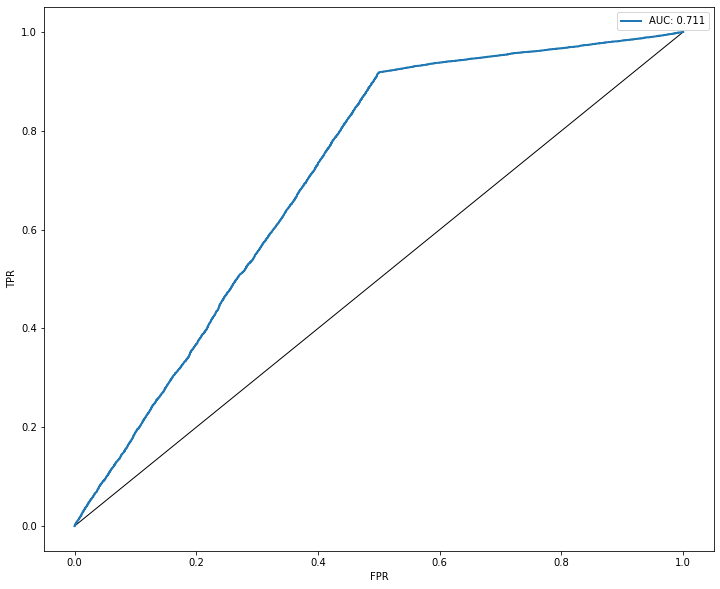

In [44]:
plot1 = membership_inference_attack_binary(high_priv_model, resampled_features, test_features, resampled_labels, test_labels)


Predict on train...
Predict on test...
Apply softmax to get probabilities from logits...
Compute losses...
Best-performing attacks over all slices
  LOGISTIC_REGRESSION (with 61503 training and 61503 test examples) achieved an AUC of 0.72 on slice Entire dataset
  LOGISTIC_REGRESSION (with 61503 training and 61503 test examples) achieved an advantage of 0.43 on slice Entire dataset

Best-performing attacks over slice: "Entire dataset"
  LOGISTIC_REGRESSION (with 61503 training and 61503 test examples) achieved an AUC of 0.72
  LOGISTIC_REGRESSION (with 61503 training and 61503 test examples) achieved an advantage of 0.43

Best-performing attacks over slice: "CLASS=0"
  THRESHOLD_ATTACK (with 180972 training and 56554 test examples) achieved an AUC of 0.50
  LOGISTIC_REGRESSION (with 56554 training and 56554 test examples) achieved an advantage of 0.01

Best-performing attacks over slice: "CLASS=1"
  LOGISTIC_REGRESSION (with 4949 training and 4949 test examples) achieved an AUC of 0.54

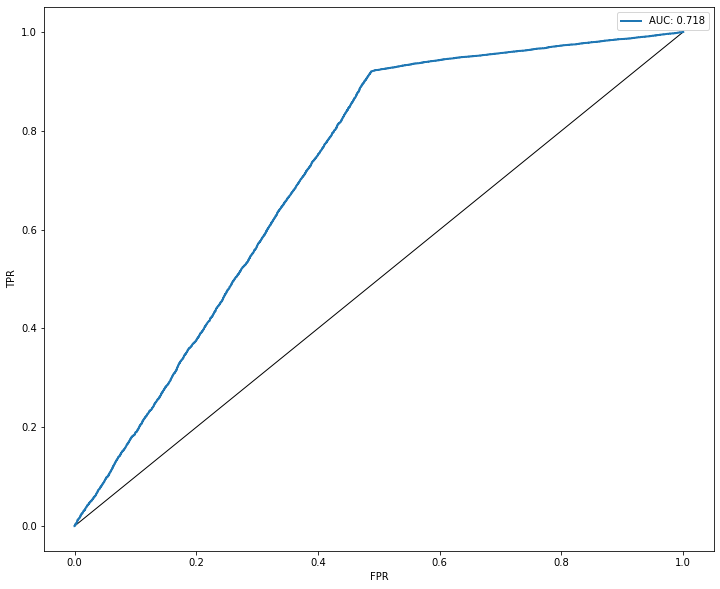

In [45]:
plot2= membership_inference_attack_binary(low_priv_model, resampled_features, test_features, resampled_labels, test_labels)


Predict on train...
Predict on test...
Apply softmax to get probabilities from logits...
Compute losses...
Best-performing attacks over all slices
  LOGISTIC_REGRESSION (with 61503 training and 61503 test examples) achieved an AUC of 0.71 on slice Entire dataset
  LOGISTIC_REGRESSION (with 61503 training and 61503 test examples) achieved an advantage of 0.43 on slice Entire dataset

Best-performing attacks over slice: "Entire dataset"
  LOGISTIC_REGRESSION (with 61503 training and 61503 test examples) achieved an AUC of 0.71
  LOGISTIC_REGRESSION (with 61503 training and 61503 test examples) achieved an advantage of 0.43

Best-performing attacks over slice: "CLASS=0"
  THRESHOLD_ATTACK (with 180972 training and 56554 test examples) achieved an AUC of 0.50
  LOGISTIC_REGRESSION (with 56554 training and 56554 test examples) achieved an advantage of 0.01

Best-performing attacks over slice: "CLASS=1"
  LOGISTIC_REGRESSION (with 4949 training and 4949 test examples) achieved an AUC of 0.57

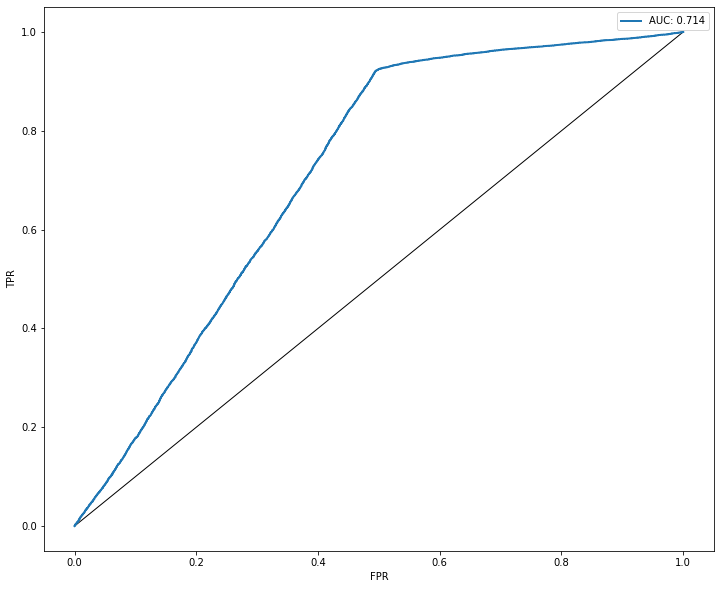

In [46]:
plot3=membership_inference_attack_binary(base_line_model, resampled_features, test_features, resampled_labels, test_labels)
